In [16]:
from pyaudi import gdual, sin, cos, tanh, exp
import pyaudi
import theano
import theano.tensor as T
import lasagne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import pickle
import time
%matplotlib inline

What's faster: sigmoid or tanh?
-----

In [828]:
a = [gdual(np.random.randn(), s, 7) for s in 'abcfe']

In [829]:
b = (a[0] + a[1] + a[2] + a[3] + a[4]) ** 10

In [830]:
%timeit 1 / (1 + exp(-b))

100 loops, best of 3: 9.43 ms per loop


In [831]:
%timeit 0.5 + 0.5 * tanh(b / 2)

100 loops, best of 3: 17.1 ms per loop


In [832]:
%timeit tanh(b)

100 loops, best of 3: 17.3 ms per loop


Neural network
-----

In [2]:
def isfunction(x):
    return hasattr(x, '__call__')

In [3]:
class PyNeuralNetwork:
    def __init__(self, num_inputs):
        self.num_outputs = num_inputs
        self.num_inputs = num_inputs
        self.layers = []
        
    def __call__(self, values):
        for layer in self.layers:
            values = layer(values)
            
        if len(values) == 1:
            return values[0]
        
        return values
    
    def get_all_parameters(self):
        for layer in self.layers:
            for parameter in layer.get_parameters():
                yield(parameter)
                
    def set_all_parameters(self, parameters):
        for layer in self.layers:
            parameters = layer.set_parameters(parameters)

In [4]:
class PyDenseLayer:
    def __init__(self, incoming, num_units, W=np.random.randn, b=0.0, nonlinearity=tanh):
        num_inputs = incoming.num_outputs

        parameters = []

        if isfunction(b):
            bias_fun = b
        else:
            bias_fun = lambda: b

        if isfunction(W):
            weight_fun = W
        else:
            weight_fun = lambda: W

        for i in range(num_inputs):
            #parameters.append(np.array([weight_fun() for unit in range(num_units)]))
            parameters.append(np.array([gdual(weight_fun(), 'w_{{{0},{1},{2}}}'.format(len(incoming.layers), unit, i), 1) for unit in range(num_units)]))
            
        #parameters.append(np.array([bias_fun() for unit in range(num_units)]))
        parameters.append(np.array([gdual(bias_fun(), 'b_{{{0},{1}}}'.format(len(incoming.layers), unit), 1) for unit in range(num_units)]))
        
        self.nonlinearity = np.vectorize(nonlinearity)
        self.parameters = parameters
        self.addmul = np.vectorize(lambda a, b, c: a + b * c)
        incoming.layers.append(self)
        incoming.num_outputs = num_units
        
    def __call__(self, input_values):
        output_values = self.parameters[-1]
        
        for input_unit, weights in zip(input_values, self.parameters):
            #output_values += weights * input_unit
            output_values = self.addmul(output_values, weights, input_unit)
        
        output_values = self.nonlinearity(output_values)
        
        return output_values
    
    def get_parameters(self):
        for unit_parameters in self.parameters:
            for parameter in unit_parameters:
                yield(parameter)
                
    def set_parameters(self, parameters):
        start_index = 0
        
        for unit in range(len(self.parameters)):
            length = len(self.parameters[unit])
            self.parameters[unit] = parameters[start_index:start_index + length]
            start_index += length
            
        return parameters[start_index:]

In [5]:
class CNeuralNetwork:
    def __init__(self, num_inputs):
        self.nn = pyaudi.NeuralNetwork(num_inputs)
        
    def __call__(self, values):
        values = self.nn(values)
            
        if len(values) == 1:
            return values[0]
        
        return values
    
    def get_all_parameters(self):
        for layer in self.nn.get_layers():
            for parameter in layer.get_parameters():
                yield(parameter)
                
    def set_all_parameters(self, parameters):
        start = 0
        
        for layer in self.nn.get_layers():
            length = len(layer.get_parameters())
            layer.set_parameters(parameters[start:start+length])
            start += length
            
def CDenseLayer(incoming, num_units, W=np.random.randn, b=0.0, nonlinearity=tanh):
    if isfunction(b):
        bias_fun = b
    else:
        bias_fun = lambda: b

    if isfunction(W):
        weight_fun = W
    else:
        weight_fun = lambda: W

    dl = pyaudi.DenseLayer(len(incoming.nn.get_layers()), incoming.nn.num_outputs, num_units, weight_fun, bias_fun, nonlinearity)
    incoming.nn.add_layer(dl)
    return dl

NeuralNetwork = CNeuralNetwork
DenseLayer = CDenseLayer

In [5]:
class OldNeuralNetwork:
    def __init__(self, num_inputs, to_gdual=False, order=None):
        if order is None:
            order = 1

        self.input_gdual = to_gdual
        self.num_outputs = num_inputs
        self.num_inputs = num_inputs
        self.order = order
        self.layers = []
        
    def __call__(self, values):
        if self.input_gdual:
            values = [gdual(value, 'x_{{{0}}}'.format(i), self.order) for i, value in enumerate(values)]

        for layer in self.layers:
            values = layer(values)
            
        if len(values) == 1:
            return values[0]
        return values
    
    def get_all_parameters(self):
        for layer in self.layers:
            for parameter in layer.get_parameters():
                yield(parameter)
                
    def set_all_parameters(self, parameters):
        for layer in self.layers:
            parameters = layer.set_parameters(parameters)

In [6]:
class OldDenseLayer:
    def __init__(self, incoming, num_units, W=np.random.randn, b=0, nonlinearity=tanh, to_gdual=True):
        num_inputs = incoming.num_outputs
        order = incoming.order

        parameters = []

        self.layer_id = len(incoming.layers) + 1

        if isfunction(b):
            bias_fun = b
        else:
            bias_fun = lambda: b

        if isfunction(W):
            weight_fun = W
        else:
            weight_fun = lambda: W

        for unit in range(num_units):
            if to_gdual:
                bias = gdual(bias_fun(), 'b_{{{0},{1}}}'.format(self.layer_id, unit), order)
            else:
                bias = bias_fun()

            unit_parameters = [bias]

            for i in range(num_inputs):
                if to_gdual:
                    weight = gdual(weight_fun(), 'w_{{{0},{1},{2}}}'.format(self.layer_id, unit, i), order)
                else:
                    weights = weight_fun()
                unit_parameters.append(weight)

            parameters.append(unit_parameters)

        self.nonlinearity = nonlinearity
        self.parameters = parameters
        incoming.layers.append(self)
        incoming.num_outputs = num_units
        
    def __call__(self, input_values):
        output_values = []
        
        for unit_parameters in self.parameters:
            output = unit_parameters[0]

            for input_unit, weight in zip(input_values, unit_parameters[1:]):
                output += weight * input_unit

            output_values.append(self.nonlinearity(output))
        
        return output_values
    
    def get_parameters(self):
        for unit_parameters in self.parameters:
            for parameter in unit_parameters:
                yield(parameter)
                
    def set_parameters(self, parameters):
        start_index = 0
        
        for unit in range(len(self.parameters)):
            length = len(self.parameters[unit])
            self.parameters[unit] = parameters[start_index:start_index + length]
            start_index += length
            
        return parameters[start_index:]

In [12]:
def squared_error(a, b):
    return (a - b) ** 2

In [13]:
def old_sgd(loss, params, learning_rate):
    derivative_index = list(np.zeros(loss.symbol_set_size))
    
    new_parameters = []

    for param in params:
        index = loss.symbol_set.index(param.symbol_set[0])

        derivative_index[index] = 1

        new_parameters.append(param - loss.get_derivative(derivative_index) * learning_rate)

        derivative_index[index] = 0
        
    return new_parameters

In [20]:
def sgd(loss, params, learning_rate):
    new_parameters = []

    for param in params:
        new_parameters.append(param - loss.get_derivative({'d' + param.symbol_set[0]: 1}) * learning_rate)

    return new_parameters

In [21]:
nn = NeuralNetwork(3)

In [22]:
DenseLayer(nn, 5)
DenseLayer(nn, 5)
DenseLayer(nn, 1)

In [23]:
loss = squared_error(nn([1, 2, 3]), 5)

In [24]:
parameters = nn.get_all_parameters()

learning_rate = 0.01

nn.set_all_parameters(sgd(loss, nn.get_all_parameters(), learning_rate))

In [25]:
for epoch in range(100):
    loss = squared_error(nn(np.array([1, 2, 3])), -0.5)
    
    parameters = nn.get_all_parameters()

    learning_rate = 0.01

    nn.set_all_parameters(sgd(loss, nn.get_all_parameters(), learning_rate))

In [26]:
nn(np.array([1, 2, 3])).constant_cf

-0.49999995733628

#### test pickling

In [32]:
with open('test.pkl', 'wb') as f:
    pickle.dump(loss, f)

with open('test.pkl', 'rb') as f:
    unpickled = pickle.load(f)
    
loss == unpickled

True

### GDual Input

In [2183]:
order = 1
values = np.array([1, 2, 3])
values = [gdual(value, 'x_{{{0}}}'.format(i), order) for i, value in enumerate(values)]

In [2184]:
nn.set_all_parameters([x.constant_cf for x in nn.get_all_parameters()])

In [2185]:
nn(values)

-0.074339*dx_{2}+0.0991623*dx_{1}-0.500454+0.0493509*dx_{0}

let's try Carlos' testcase
-----

In [2121]:
n_units = [3, 5, 5, 1]

In [2122]:
x1 = 1
x2 = 2
x3 = 4

nn = NeuralNetwork(n_units[0])
for num_units in n_units[1:]:
    DenseLayer(nn, num_units, b=1)

N = nn([x1,x2, x3])
print('N(x) = {0}'.format(N.constant_cf))

N(x) = 0.8683431028474348


#### Loss function

In [2124]:
def y_f(x):
    return x[0]*x[1] + 0.5*x[2] + 2

y = y_f([x1,x2,x3])
print('y = {0}'.format(y))

y = 6.0


In [2125]:
loss = squared_error(N, y)
print('loss = {0}'.format(loss.constant_cf))

loss = 22.81778869227971


In [2126]:
parameters = sgd(loss, nn.get_all_parameters(), 0.01)

nn.set_all_parameters(parameters)
N = nn([x1,x2,x3])
loss = squared_error(N, y)
print('loss = {0}'.format(loss.constant_cf))

loss = 19.15402101274607


In [2127]:
X = -1+2*np.random.rand(10,3)

epoch 49, training loss: 0.05968504698950948


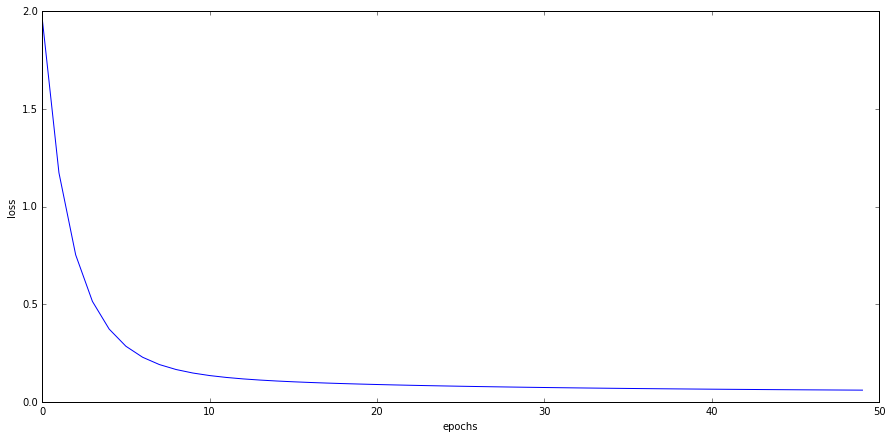

In [2128]:
loss_history = []

nn = NeuralNetwork(n_units[0])
for num_units in n_units[1:-1]:
    DenseLayer(nn, num_units, b=1)
DenseLayer(nn, n_units[-1], b=1, nonlinearity=lambda x: x)

epochs = 50

for e in range(epochs):
        
    #Just records the error at the beginning of this step
    epoch_loss = []
    for xi in X:
        N = nn(xi)
        loss = squared_error(N, y_f(xi))
        epoch_loss.append(loss.constant_cf)
        
    loss_history.append(np.mean(epoch_loss))
    
    #Updates the weights
    for xi in X:
        N = nn(xi)
        loss = squared_error(N, y_f(xi))
        parameters = sgd(loss, nn.get_all_parameters(), 0.001)
        nn.set_all_parameters(parameters)

print('epoch {0}, training loss: {1}'.format(e, loss_history[-1]))        
plt.plot(loss_history)
plt.xlabel('epochs')
plt.ylabel('loss')

### $(thrust, d_\theta)$ control, fixed initial state

state: $(x,y,\theta)$

dynamics: $dx = u_1sin(\theta)$, $dy = u_1cos(\theta)$, $d_\theta = u_2$

In [2129]:
def dy(state, u, t):
    state[0] += sin(state[2])*u[1]*t
    state[1] += cos(state[2])*u[1]*t
    state[2] += u[0]
    return state

In [2130]:
# Initial state
x = 5
y = 5
theta = 0

state = [x,y,theta]

In [2131]:
n_units = [3, 10, 10, 2]

In [2133]:
nn = NeuralNetwork(n_units[0])
for num_units in n_units[1:-1]:
    DenseLayer(nn, num_units, b=0.01, W=lambda: 0.01 * np.random.randn())
DenseLayer(nn, n_units[-1], b=0.01, nonlinearity=lambda x: x, W=lambda: 0.01 * np.random.randn())

In [2134]:
trajs = []

In [2135]:
t = 0.2
for epoch in range(200):
    traj = []
    state = [x,y,theta]
    traj.append((state[0], state[1]))
    for i in range(10):
        N = nn(state)
        u = [N[0], N[1]]
        state = dy(state, u, t)
        traj.append((state[0].constant_cf, state[1].constant_cf))

    loss = (state[0]**2 + state[1]**2)

    parameters = sgd(loss, nn.get_all_parameters(), 0.001)
    nn.set_all_parameters(parameters)
    trajs.append(traj)

KeyboardInterrupt: 

In [ ]:
plt.rcParams['figure.figsize'] = (15,7)

for i in range(0,len(trajs),5):
    traj = np.asarray(trajs[i])
    plt.plot(traj[:,0], traj[:,1], color='gray')    

for t in trajs[-10:]:
    traj = np.asarray(t)
    plt.plot(traj[:,0], traj[:,1], color='gray')    
    
traj = np.asarray(trajs[0])
first_traj, = plt.plot(traj[:,0], traj[:,1], color='red', label='First trajectory')
    
traj = np.asarray(trajs[-1])
last_traj, = plt.plot(traj[:,0], traj[:,1], color='green', label='Last trajectory')

plt.legend(handles=[first_traj, last_traj])

### $(d_x, d_y)$ control, fixed initial state

In [2136]:
n_units = [2, 5, 5, 2]

In [2137]:
def dy(state, u, t):
    state[0] += u[0]*t
    state[1] += u[1]*t
    return state

In [2138]:
# Initial state
x = 10
y = 10

state = [x,y]

In [2139]:
# NN definition
nn = NeuralNetwork(n_units[0])
for num_units in n_units[1:-1]:
    DenseLayer(nn, num_units, b=1)
DenseLayer(nn, n_units[-1], b=1, nonlinearity=lambda x: x)
trajs = []

In [2140]:
t = 0.1
for epoch in range(50):
    traj = []
    state = [x,y]
    traj.append((state[0], state[1]))
    for i in range(20):
        N = nn(state)
        u = [N[0], N[1]]
        state = dy(state, u, t)
        traj.append((state[0].constant_cf, state[1].constant_cf))

    loss = (state[0]**2 + state[1]**2)
    parameters = sgd(loss, nn.get_all_parameters(), 0.001)
    nn.set_all_parameters(parameters)
    trajs.append(traj)

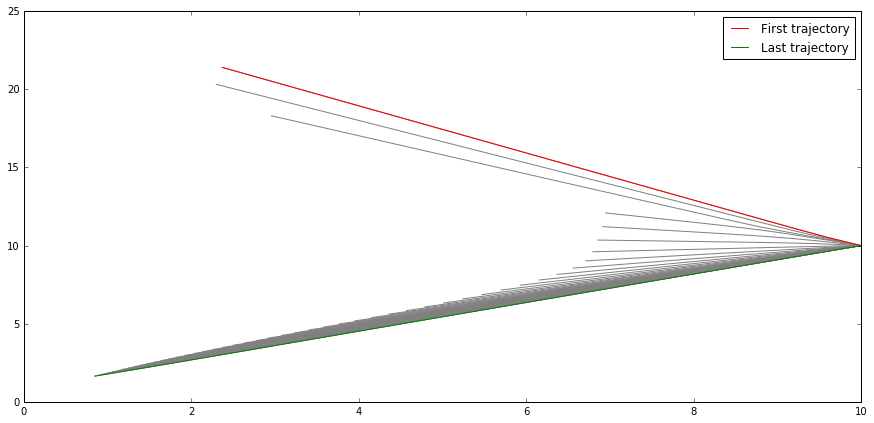

In [2141]:
plt.rcParams['figure.figsize'] = (15,7)

    
for t in trajs:
    traj = np.asarray(t)
    plt.plot(traj[:,0], traj[:,1], color='gray')
 
    
traj = np.asarray(trajs[0])
first_traj, = plt.plot(traj[:,0], traj[:,1], color='red', label='First trajectory')
    
traj = np.asarray(trajs[-1])
last_traj, = plt.plot(traj[:,0], traj[:,1], color='green', label='Last trajectory')

plt.legend(handles=[first_traj, last_traj])


Integrators
-------

In [6]:
def euler(state, differential, time_step):
    update = differential(state)
    return [x + dx * time_step for x, dx in zip(state, update)]

In [7]:
def runge_kutta4(state, differential, time_step):
    k1 = differential(state)
    k2 = differential([x + time_step / 2 * dx for x, dx in zip(state, k1)])
    k3 = differential([x + time_step / 2 * dx for x, dx in zip(state, k2)])
    k4 = differential([x + time_step     * dx for x, dx in zip(state, k3)])
    return [x + time_step / 6 * (dx1 + 2 * (dx2 + dx3) + dx4) for x, dx1, dx2, dx3, dx4 in zip(state, k1, k2, k3, k4)]

#### let's test them moving in a circle

In [13]:
def circle_move(state):
    speed = np.pi / 100
    length = np.sqrt(state[0] ** 2 + state[1] ** 2)
    velocity = [speed * state[1] / length, - speed * state[0] / length]
    return velocity

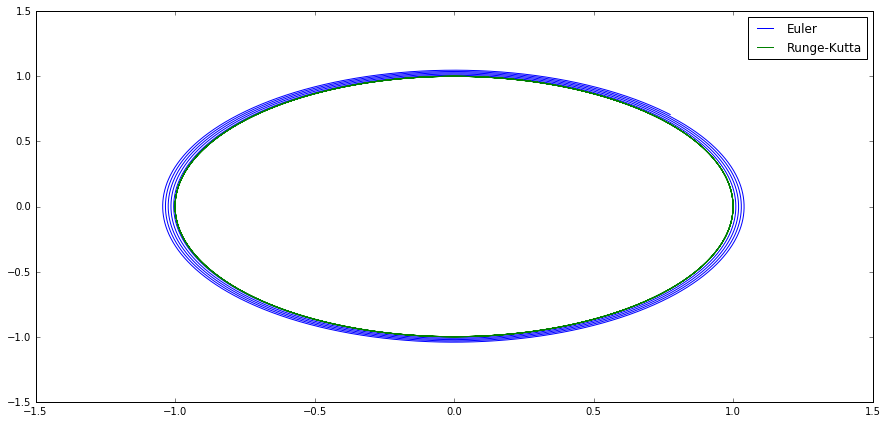

In [2145]:
for name, integrator in [('Euler', euler), ('Runge-Kutta', runge_kutta4)]:
    state = [1, 0]
    positions = [state]

    for i in range(10000):
        state = integrator(state, circle_move, 0.1)
        positions.append(state)

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)
    plt.legend()

Quadrotor Models
---------------

we use a neural network that controls a quadcopter, either the gdual network or a lasagne network

In [8]:
class Quadrotor:
    def __init__(self):
        n_units = [3, 10, 10, 2]
        
        nn = NeuralNetwork(n_units[0])
        for num_units in n_units[1:-1]:
            DenseLayer(nn, num_units, b=1)
        DenseLayer(nn, n_units[-1], b=1, nonlinearity=lambda x: x)
        
        self.nn = nn
        
    def control(self, state):
        u = self.nn(state)
        
        return [sin(state[2]) * u[0], cos(state[2]) * u[0], u[1]]
    
    def get_parameters(self):
        parameters = self.nn.get_all_parameters()
        
        return list(parameters)
    
    def set_parameters(self, parameters):
        self.nn.set_all_parameters(parameters)

In [9]:
class TQuadrotor:
    def __init__(self):
        n_units = [3, 10, 10, 2]
        
        nn = lasagne.layers.InputLayer((None, n_units[0],))
        input_var = nn.input_var
        
        for num_units in n_units[1:-1]:
            nn = lasagne.layers.DenseLayer(nn, num_units, nonlinearity=lasagne.nonlinearities.tanh)
        nn = lasagne.layers.DenseLayer(nn, n_units[-1], nonlinearity=lasagne.nonlinearities.linear)
        
        self.nn = nn
        
        prediction = lasagne.layers.get_output(nn, deterministic=True)
        pred_fn = theano.function([input_var], prediction)
        
        self.prediction = pred_fn
        
        self.n_units = n_units
    
    def control(self, state):
        u = self.prediction((state, ))
        
        return [sin(state[2]) * u[0, 0], cos(state[2]) * u[0, 0], u[0, 1]]
    
    def get_parameters(self):
        parameters = lasagne.layers.get_all_param_values(self.nn)

        params = []

        for layer_id in range(len(parameters) // 2):
            weights = parameters[layer_id * 2]
            biases = parameters[layer_id * 2 + 1]

            params = np.hstack([params, weights.reshape(-1), biases])

        return params
    
    def set_parameters(self, params):
        parameters = []
        
        n_units = self.n_units

        start = 0
        for layer_id in range(1, len(n_units)):
            num_units = n_units[layer_id]
            prev_units = n_units[layer_id - 1]

            weights = np.array(params[start:start + prev_units * num_units]).reshape(prev_units, num_units)

            start += prev_units * num_units
            
            biases = np.array(params[start:start + num_units])
            
            start += num_units

            parameters += [weights, biases]

        lasagne.layers.set_all_param_values(self.nn, parameters)

Compare with Lasagne
---------------

let's check if we get the same result with lasagne as with our network

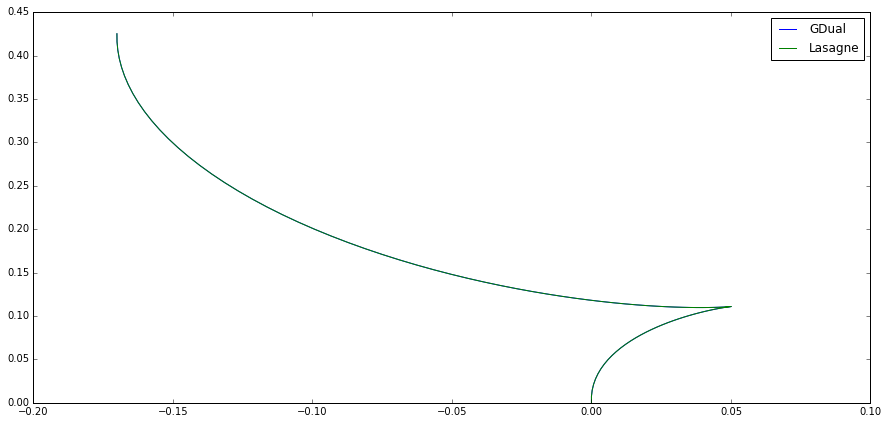

In [2205]:
# Initial state
x = 0
y = 0
theta = 0

# training parameters
integrator = euler

# two quadrotor neural networks
quad = Quadrotor()
tquad = TQuadrotor()
tquad.set_parameters([x.constant_cf for x in quad.nn.get_all_parameters()])

for name, quadrotor in [('GDual', quad), ('Lasagne', tquad)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.01)
        if name == 'GDual':
            positions.append([x.constant_cf for x in state])
        else:
            positions.append(state)

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)
    plt.legend()

Influence of the Integrator
---------------

we use a neural network that controls a quadcopter, integrate it for a while and check how the result changes with changing the integrator

In [429]:
# Initial state
x = 0
y = 0
theta = 0

In [430]:
quadrotor = Quadrotor()

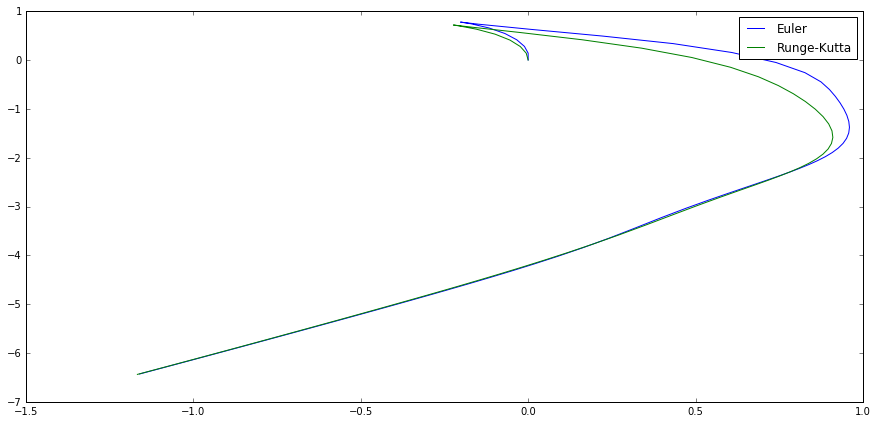

In [431]:
for name, integrator in [('Euler', euler), ('Runge-Kutta', runge_kutta4)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.1)
        positions.append([x.constant_cf for x in state])

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)
    plt.legend()

In [432]:
quadrotor = Quadrotor()

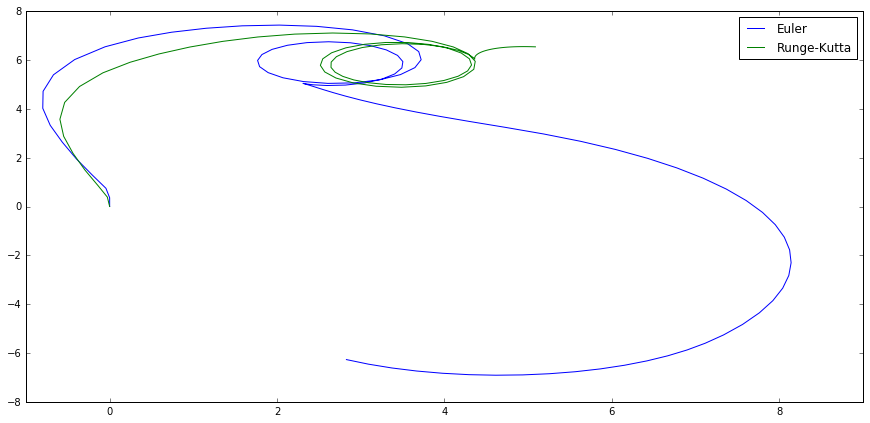

In [433]:
for name, integrator in [('Euler', euler), ('Runge-Kutta', runge_kutta4)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.1)
        positions.append([x.constant_cf for x in state])

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)
    plt.legend()

In [434]:
quadrotor = Quadrotor()

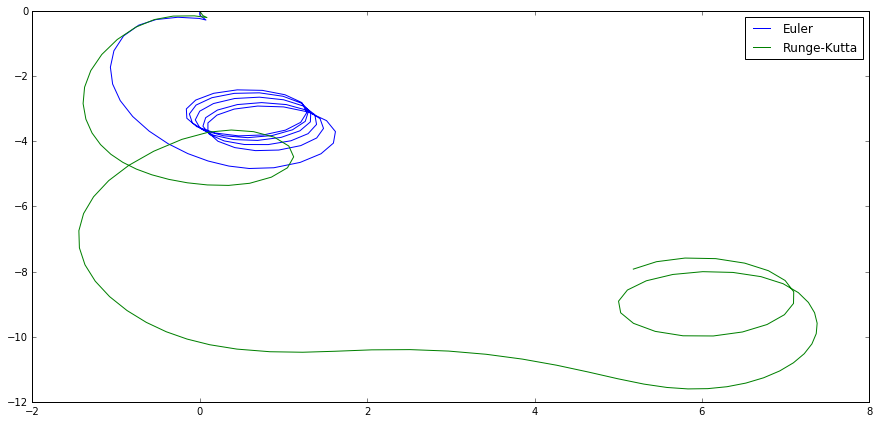

In [435]:
for name, integrator in [('Euler', euler), ('Runge-Kutta', runge_kutta4)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.1)
        positions.append([x.constant_cf for x in state])

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)
    plt.legend()

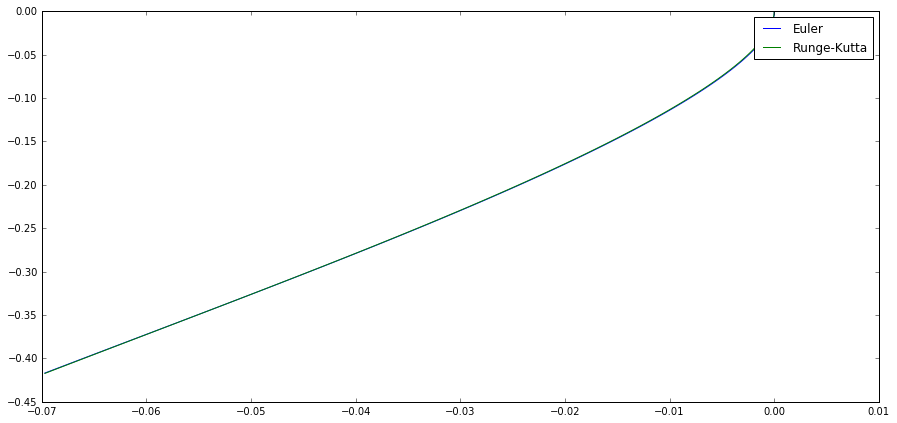

In [436]:
quadrotor = Quadrotor()

for name, integrator in [('Euler', euler), ('Runge-Kutta', runge_kutta4)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.01)
        positions.append([x.constant_cf for x in state])

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)
    plt.legend()

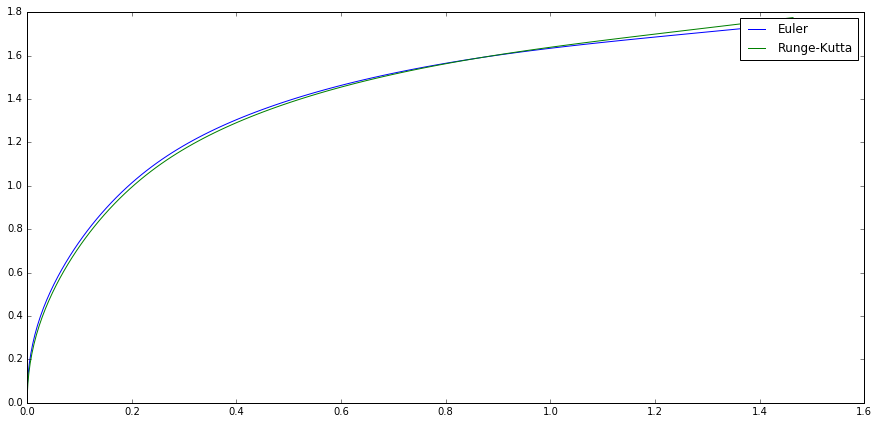

In [437]:
quadrotor = Quadrotor()

for name, integrator in [('Euler', euler), ('Runge-Kutta', runge_kutta4)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.01)
        positions.append([x.constant_cf for x in state])

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)
    plt.legend()

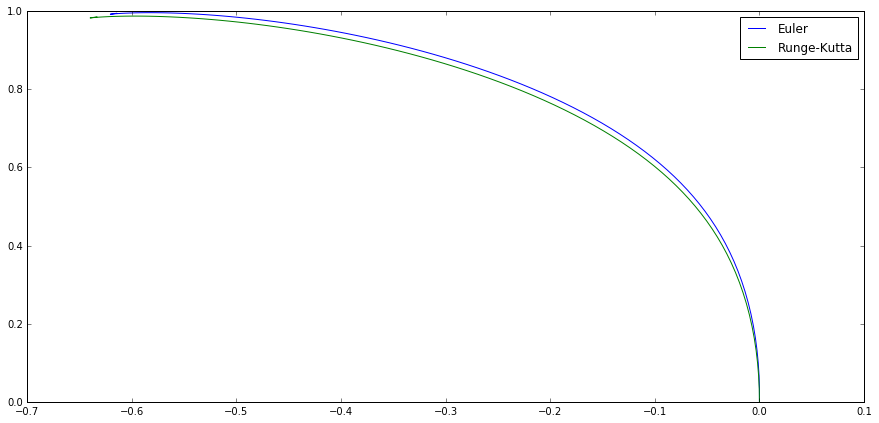

In [438]:
quadrotor = Quadrotor()

for name, integrator in [('Euler', euler), ('Runge-Kutta', runge_kutta4)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.01)
        positions.append([x.constant_cf for x in state])

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)
    plt.legend()

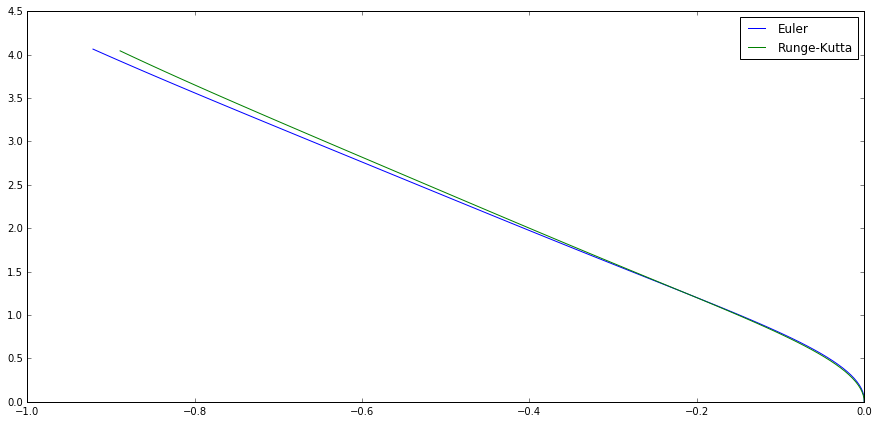

In [439]:
quadrotor = Quadrotor()

for name, integrator in [('Euler', euler), ('Runge-Kutta', runge_kutta4)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.01)
        positions.append([x.constant_cf for x in state])

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)
    plt.legend()

Dario: quick check how small weight change influences outcome
----

/usr/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


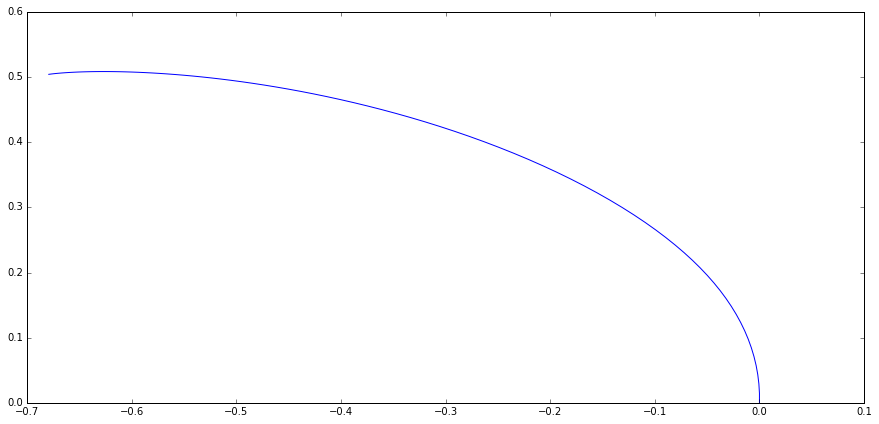

In [2191]:
# Initial state
x = 0
y = 0
theta = 0

# training parameters
integrator = euler

# two quadrotor neural networks
quad = Quadrotor()
tquad = TQuadrotor()
tquad.set_parameters([x.constant_cf for x in quad.nn.get_all_parameters()])

for name, quadrotor in [('Lasagne', tquad)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.01)
        if name == 'GDual':
            positions.append([x.constant_cf for x in state])
        else:
            positions.append(state)

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1])
    plt.legend()

/usr/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


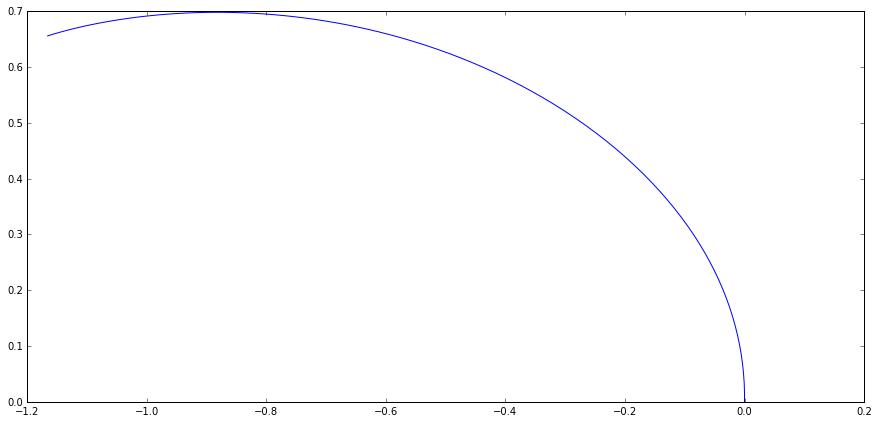

In [2192]:
tquad.set_parameters([x.constant_cf for x in quad.nn.get_all_parameters()] + 0.1 * np.random.random(size=len(list(quad.nn.get_all_parameters()))))

for name, quadrotor in [('Lasagne', tquad)]:
    state = [x,y,theta]
    positions = [state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.01)
        if name == 'GDual':
            positions.append([x.constant_cf for x in state])
        else:
            positions.append(state)

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1])
    plt.legend()

Create the full expression with theano
------------

In [728]:
class THugeQuadrotor:
    def __init__(self, parameters):
        n_units = [3, 10, 10, 2]
        self.n_units = n_units
        self.input_var = None
        self.set_parameters(parameters)
        
    def control(self, state, time_step):
        n_units = self.n_units
        
        nn = lasagne.layers.InputLayer((None, n_units[0],), state)
        
        if state is None:
            input_var = nn.input_var
            state = input_var
            self.input_var = input_var

        for num_units, W, b in zip(n_units[1:-1], self.parameters[::2], self.parameters[1::2]):
            nn = lasagne.layers.DenseLayer(nn, num_units, nonlinearity=lasagne.nonlinearities.tanh, W=W, b=b)

        W = self.parameters[-2]
        b = self.parameters[-1]
        nn = lasagne.layers.DenseLayer(nn, n_units[-1], nonlinearity=lasagne.nonlinearities.linear, W=W, b=b)
        
        u = lasagne.layers.get_output(nn, deterministic=True) * time_step
        
        return T.stack([T.sin(state[:, 2]) * u[:, 0], T.cos(state[:, 2]) * u[:, 0], u[:, 1]]).transpose()
    
    def create_function(self, state):
        prediction = state
        pred_fn = theano.function([self.input_var], prediction, mode='FAST_COMPILE')
        
        self.prediction = pred_fn
        
    def predict(self, state):
        return self.prediction((state, ))
    
    def set_parameters(self, params):
        parameters = []

        flattened = np.zeros(len(params))
        
        start = 0
        for layer_id in range(1, len(n_units)):
            num_units = n_units[layer_id]
            prev_units = n_units[layer_id - 1] + 1

            layer = np.array(params[start:start + prev_units * num_units]).reshape(num_units, prev_units).transpose().reshape(-1)

            flattened[start:start + prev_units * num_units] = layer

            start += prev_units * num_units
        
        params = theano.shared(flattened)
        self.flat = params

        start = 0
        for layer_id in range(1, len(n_units)):
            num_units = n_units[layer_id]
            prev_units = n_units[layer_id - 1]

            biases = params[start:start + num_units]
            start += num_units
            
            weights = params[start:start + prev_units * num_units].reshape((prev_units, num_units))

            parameters += [weights, biases]

            start += prev_units * num_units
            
        self.parameters = parameters

In [698]:
thquad = THugeQuadrotor([x.constant_cf for x in quad.nn.get_all_parameters()])

In [714]:
#tquad.set_parameters([x.constant_cf for x in quad.nn.get_all_parameters()] + 0.01 * np.random.random(size=len(list(quad.nn.get_all_parameters()))))

time_step = 0.01

state = None

for i in range(100):
    update = thquad.control(state, time_step)
    if state is None:
        state = thquad.input_var
    state = state + update

In [715]:
thquad.create_function(state)

INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/jo

In [727]:
actual_state = [x,y,theta]

#thquad.predict(actual_state)
thquad.prediction(np.array([actual_state]))

array([[ 1.17964656,  0.83783939,  1.0673905 ]])

In [741]:
thquad2 = THugeQuadrotor([x.constant_cf for x in quad.nn.get_all_parameters()])

In [742]:
time_step = 0.01

state = None

for i in range(100):
    update = thquad2.control(state, time_step)
    if state is None:
        state = thquad2.input_var
    state = state + update

In [743]:
thquad2.create_function(state)

In [744]:
actual_state = [x,y,theta]

#thquad.predict(actual_state)
thquad2.prediction(np.array([actual_state]))

array([[ 1.17964656,  0.83783939,  1.0673905 ]])

In [745]:
import sys

In [746]:
sys.setrecursionlimit(10000)

In [748]:
foo = state.sum()
hessian = theano.gradient.hessian(foo, thquad2.flat)

pred_fn = theano.function([thquad2.input_var], hessian)

INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock


In [749]:
pred_fn((actual_state,))

MethodNotDefined: ('perform', <class 'theano.tensor.elemwise.Elemwise'>, 'Elemwise', 'Did you used Theano flags mode=FAST_COMPILE? You can use optimizer=fast_compile instead.')
Apply node that caused the error: Elemwise{add,no_inplace}(InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, input, InplaceDimShuffle{1,0}.0)
Toposort index: 815
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3)]
Inputs strides: [(24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8), (24, 8)]
Inputs values: [array([[ 0.00692003,  0.00747158,  0.02168303]]), array([[ 0.00661079,  0.00746211,  0.02211449]]), array([[ 0.00631139,  0.007456  ,  0.02252794]]), array([[ 0.00602148,  0.00745345,  0.02292448]]), array([[ 0.0057405 ,  0.00745455,  0.02330493]]), array([[ 0.00546784,  0.00745923,  0.02366967]]), array([[ 0.00520279,  0.00746736,  0.0240186 ]]), array([[ 0.00494467,  0.00747876,  0.02435106]]), array([[ 0.00469285,  0.00749327,  0.02466586]]), array([[ 0.00444675,  0.00751075,  0.0249613 ]]), array([[ 0.00420589,  0.00753116,  0.02523534]]), array([[ 0.00396985,  0.00755452,  0.02548561]]), array([[ 0.00373827,  0.00758094,  0.02570962]]), array([[ 0.00351084,  0.0076106 ,  0.02590479]]), array([[ 0.00328729,  0.00764375,  0.02606856]]), array([[ 0.00306734,  0.00768069,  0.02619845]]), array([[ 0.00285073,  0.00772174,  0.0262921 ]]), array([[ 0.00263718,  0.00776726,  0.0263473 ]]), array([[ 0.0024264 ,  0.00781756,  0.02636201]]), array([[ 0.00221809,  0.00787297,  0.02633436]]), array([[ 0.00201191,  0.00793376,  0.02626272]]), array([[ 0.00180755,  0.00800016,  0.02614564]]), array([[ 0.00160465,  0.00807231,  0.02598194]]), array([[ 0.00140287,  0.00815027,  0.02577073]]), array([[ 0.00120189,  0.00823398,  0.0255114 ]]), array([[ 0.00100142,  0.00832326,  0.02520373]]), array([[ 0.00080119,  0.00841779,  0.02484781]]), array([[ 0.00060101,  0.00851713,  0.02444415]]), array([[ 0.00040076,  0.00862069,  0.02399361]]), array([[ 0.0002004 ,  0.00872773,  0.02349741]]), array([[ 0.,  0.,  0.]]), array([[ 0.        ,  0.00883744,  0.0229571 ]])]
Outputs clients: [[InplaceDimShuffle{1,0}(Elemwise{add,no_inplace}.0), Dot22(Elemwise{add,no_inplace}.0, Reshape{2}.0), Subtensor{::, int64}(Elemwise{add,no_inplace}.0, Constant{2}), for{cpu,scan_fn}(Shape_i{0}.0, Subtensor{int64:int64:int8}.0, Shape_i{0}.0, IncSubtensor{InplaceInc;int64:int64:}.0, input.T, MakeVector{dtype='int64'}.0, MakeVector{dtype='int64'}.0, MakeVector{dtype='int64'}.0, input, Elemwise{cos,no_inplace}.0, Elemwise{sin,no_inplace}.0, Alloc.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1,0}.0, Reshape{2}.0, Reshape{2}.0, Reshape{2}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Alloc.0, Alloc.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)].0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{cos,no_inplace}.0, Elemwise{sin}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Subtensor{::, int64}.0, InplaceDimShuffle{1,0}.0, Elemwise{sin}.0, Elemwise{cos,no_inplace}.0, Elemwise{add,no_inplace}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, Elemwise{Composite{tanh((i0 + i1))}}.0, InplaceDimShuffle{1,0}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{Mul}[(0, 1)].0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{1}.0, InplaceDimShuffle{1}.0, Elemwise{mul}.0, Elemwise{Composite{(-(i0 * i1))}}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, InplaceDimShuffle{1,0}.0, Elemwise{mul,no_inplace}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, Dot22.0, InplaceDimShuffle{1,0}.0, Elemwise{mul}.0, MakeVector{dtype='int64'}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/joerg/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/joerg/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/joerg/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/joerg/venv/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-742-6fceb9913a40>", line 9, in <module>
    state = state + update

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [759]:
thquad3 = THugeQuadrotor([x.constant_cf for x in quad.nn.get_all_parameters()])

In [760]:
time_step = 0.01

state = None

for i in range(2):
    update = thquad3.control(state, time_step)
    if state is None:
        state = thquad3.input_var
    state = state + update

In [761]:
thquad3.create_function(state)

In [762]:
actual_state = [x,y,theta]

#thquad.predict(actual_state)
thquad3.prediction(np.array([actual_state]))

array([[ 0.0002004 ,  0.01756517,  0.0464545 ]])

In [764]:
foo = state.sum()
hessian = theano.gradient.hessian(foo, thquad3.flat)

pred_fn2 = theano.function([thquad3.input_var], hessian)

INFO (theano.gof.compilelock): Refreshing lock /home/joerg/.theano/compiledir_Linux-4.2--ARCH-x86_64-with-arch--3.5.1-64/lock_dir/lock


In [765]:
pred_fn2((actual_state,))

array([[ -8.43879815e-03,  -2.96709887e-04,   2.83037258e-03, ...,
         -4.58228263e-04,   6.07055835e-05,  -2.16274386e-05],
       [ -2.96709887e-04,  -1.35253093e-02,  -3.40995582e-03, ...,
         -2.47478347e-04,   5.43941102e-06,   3.99828042e-05],
       [  2.83037258e-03,  -3.40995582e-03,   1.11997695e-02, ...,
         -1.22163931e-04,   1.36365852e-04,   4.73615486e-05],
       ..., 
       [ -4.58228263e-04,  -2.47478347e-04,  -1.22163931e-04, ...,
         -6.84806578e-06,  -8.51980188e-05,   6.95819427e-06],
       [  6.07055835e-05,   5.43941102e-06,   1.36365852e-04, ...,
         -8.51980188e-05,   2.34789038e-06,   9.22770890e-05],
       [ -2.16274386e-05,   3.99828042e-05,   4.73615486e-05, ...,
          6.95819427e-06,   9.22770890e-05,  -7.06959940e-06]])

### conclusion: works for 2 steps, but doesn't work for 100 steps

Network performance of gduals of different oder versus number of gduals
-------------------

In [73]:
num_gduals = np.int32(np.ceil(np.logspace(0, np.log10(255), num=16)))
num_gduals

array([  1,   2,   3,   4,   5,   7,  10,  14,  20,  28,  41,  59,  85,
       122, 177, 255], dtype=int32)

In [50]:
orders = np.arange(10, dtype=np.int32)
orders

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [57]:
import multiprocessing as mp
import timeit
import time

In [53]:
n_units = [1000, 256, 1]
nn = NeuralNetwork(n_units[0])
for num_units in n_units[1:-1]:
    DenseLayer(nn, num_units, b=1)
DenseLayer(nn, n_units[-1], b=1, nonlinearity=lambda x: x)

In [54]:
parameters = [x.constant_cf for x in nn.get_all_parameters()]

In [55]:
def runnn(parameters, num_gduals, order):
    n_units = [1000, 256, 1]
    
    nn = NeuralNetwork(n_units[0])
    for num_units in n_units[1:-1]:
        DenseLayer(nn, num_units, b=1)
    DenseLayer(nn, n_units[-1], b=1, nonlinearity=lambda x: x)
    
    nn.set_all_parameters(parameters)
    
    if order == 0:
        num_gduals = 0
    
    values = [gdual(value, 'x_{{{0}}}'.format(i), order) if i < num_gduals else value for i, value in enumerate(np.random.randn(1000))]
    
    return timeit.timeit('nn(values)', number=3, globals=locals())
    
    #return nn(values)

In [67]:
all_results = []

for order in tqdm.tqdm(orders):
    pool = mp.Pool(processes = len(num_gduals))
    
    values = []

    results = [pool.apply_async(runnn, args=[parameters, x, int(order)]) for x in num_gduals]
    
    end = time.time() + 180

    for result in results:
        timeout = max(np.ceil(end - time.time()), 1)
        
        try:
            val = result.get(timeout = timeout)
        except mp.TimeoutError:
            val = 'timeout'

        values.append(val)

    pool.terminate()
    pool.join()
    
    all_results.append(values)

100%|██████████| 10/10 [28:18<00:00, 183.23s/it]


In [68]:
all_results

[[0.522825188934803,
  0.6468100696802139,
  0.5416395198553801,
  0.579417634755373,
  0.44672181084752083,
  0.5738521311432123,
  0.35574146918952465,
  0.5418730992823839,
  0.49024454690515995,
  0.47327153757214546,
  0.36016080901026726,
  0.432456461712718,
  0.3149003144353628,
  0.5044791027903557,
  0.36257808469235897,
  0.44974891282618046],
 [2.3944593220949173,
  2.5172258093953133,
  2.7328966557979584,
  3.0254808124154806,
  3.1233754996210337,
  3.1594120878726244,
  3.6908161230385303,
  3.7285466324537992,
  7.049443315714598,
  9.341266345232725,
  16.405163472518325,
  26.91434819251299,
  46.42906912975013,
  83.6345822699368,
  167.86108405515552,
  'timeout'],
 [2.6879830323159695,
  2.5982341188937426,
  3.027502566576004,
  2.7560234889388084,
  3.0364602897316217,
  3.40592191927135,
  4.2945595141500235,
  4.448793668299913,
  7.92930668219924,
  11.572455504909158,
  21.598808750510216,
  38.208024591207504,
  77.7608006130904,
  'timeout',
  'timeout',
 

In [77]:
df = pd.DataFrame(all_results, index=orders, columns=num_gduals).transpose()
df

,0,1,2,3,4,5,6,7,8,9
1,0.522825,2.39446,2.68798,2.81802,2.67308,2.31471,2.29598,2.67045,2.49192,2.42261
2,0.64681,2.51723,2.59823,2.77455,2.74904,2.96224,2.55889,2.91696,2.85828,3.06296
3,0.54164,2.7329,3.0275,2.92727,3.02156,3.40633,3.01051,3.70497,4.0369,4.21879
4,0.579418,3.02548,2.75602,2.86793,3.08703,3.44902,3.40666,4.52843,5.50655,7.77198
5,0.446722,3.12338,3.03646,3.49757,3.75782,4.12556,4.84436,7.605,timeout,timeout
7,0.573852,3.15941,3.40592,3.89825,4.51615,7.01415,timeout,timeout,timeout,timeout
10,0.355741,3.69082,4.29456,4.90211,7.586,timeout,timeout,timeout,timeout,timeout
14,0.541873,3.72855,4.44879,6.80143,timeout,timeout,timeout,timeout,timeout,timeout
20,0.490245,7.04944,7.92931,timeout,timeout,timeout,timeout,timeout,timeout,timeout
28,0.473272,9.34127,11.5725,timeout,timeout,timeout,timeout,timeout,timeout,timeout


In [78]:
with open('nn_single_run_order_vs_num_gduals.pkl', 'wb') as f:
    pickle.dump(df, f)

Influence of the Order
---------------

we use a neural network that controls a quadcopter, integrate it for a while and check how the result changes with changing the weights a bit, for different orders of gduals

In [330]:
# parameters
num_gduals = 5
order = 7

# Initial state
x = 0
y = 0
theta = 0
dt = 0.05 * 4
steps = 25

# training parameters
integrator = runge_kutta4

# two quadrotor neural networks
quad = Quadrotor()

original_parameters = np.array(quad.get_parameters())

indices = np.random.choice(np.arange(len(original_parameters), dtype=np.int32), num_gduals, False)

parameters = [x + gdual(0, order) if i in indices else gdual(x.constant_cf) for i, x in enumerate(original_parameters)]

quad.set_parameters(parameters)

state = [gdual(a) for a in [x,y,theta]]
positions = [state]

for i in tqdm.trange(steps):
    state = integrator(state, quad.control, dt)
    #positions.append([x.constant_cf for x in state])
    positions.append(state)

100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


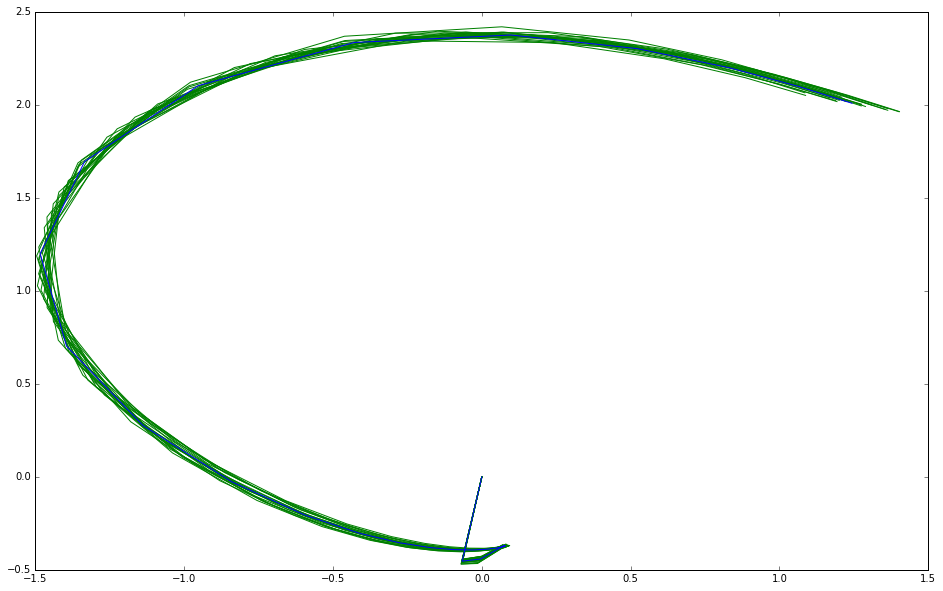

In [331]:
plt.rcParams['figure.figsize'] = (16,10)

for i in range(20):
    dw = 0.1 * (np.random.rand(num_gduals) - .5) * 2
    dw = {'d' + symbol.symbol_set[0]: x for symbol, x in zip(np.array(original_parameters)[indices], dw)}

    trajectory = np.array([[x.evaluate(dw) for x in pos] for pos in positions])

    plt.plot(trajectory[:, 0], trajectory[:, 1], c='g')

trajectory = np.array([[x.constant_cf for x in pos] for pos in positions])

plt.plot(trajectory[:, 0], trajectory[:, 1])

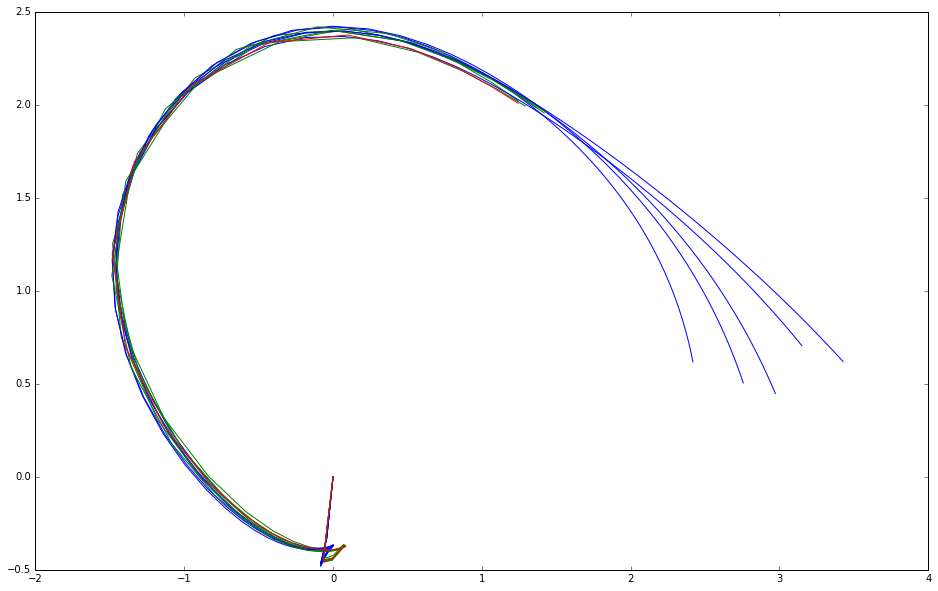

In [333]:
plt.rcParams['figure.figsize'] = (16,10)

tquad = TQuadrotor()

for i in range(5):
    dw = .1 * (np.random.rand(num_gduals) - .5) * 2

    parameters = np.array([x.constant_cf for x in original_parameters])
    parameters[indices] += dw
    
    tquad.set_parameters(parameters)

    state = [x,y,theta]
    trajectory = [state]

    for i in range(100):
        state = integrator(state, tquad.control, 0.1)
        trajectory.append(state)    
        
    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], c='b')
    
    dw = {'d' + symbol.symbol_set[0]: x for symbol, x in zip(np.array(original_parameters)[indices], dw)}

    trajectory = np.array([[x.evaluate(dw) for x in pos] for pos in positions])
    plt.plot(trajectory[:, 0], trajectory[:, 1], c='g')

trajectory = np.array([[x.constant_cf for x in pos] for pos in positions])

plt.plot(trajectory[:, 0], trajectory[:, 1], 'r')

Error plot
-------

In [19]:
# parameters
num_gduals = 5
order = 4

# Initial state
x = 0
y = 0
theta = 0
dt = 0.05 * 4
steps = 25

# training parameters
integrator = runge_kutta4

# two quadrotor neural networks
quad = Quadrotor()

original_parameters = np.array(quad.get_parameters())

indices = np.random.choice(np.arange(len(original_parameters), dtype=np.int32), num_gduals)

parameters = [x + gdual(0, order) if i in indices else gdual(x.constant_cf) for i, x in enumerate(original_parameters)]

quad.set_parameters(parameters)

state = [gdual(a) for a in [x,y,theta]]
positions = [state]

for i in tqdm.trange(steps):
    state = integrator(state, quad.control, dt)
    #positions.append([x.constant_cf for x in state])
    positions.append(state)

100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


In [20]:
num_tests = 100000
max_radius = 0.5

plt.rcParams['figure.figsize'] = (16,10)

tquad = TQuadrotor()

errors = []

tquad_time = 0
gdual_time = 0

for i in tqdm.trange(num_tests):
    dw = max_radius * (np.random.rand(num_gduals) - .5) * 2
    actual_radius = np.sqrt(np.dot(dw, dw))

    parameters = np.array([x.constant_cf for x in original_parameters])
    parameters[indices] += dw
    
    tquad.set_parameters(parameters)

    start_time = time.time()
    
    state = [x,y,theta]
    trajectory = [state]

    for i in range(steps):
        state = integrator(state, tquad.control, dt)
        trajectory.append(state)
        
    end_time = time.time()
    
    tquad_time += end_time - start_time

    actual_trajectory = np.array(trajectory)
    
    start_time = time.time()
    
    dw = {'d' + symbol.symbol_set[0]: x for symbol, x in zip(np.array(original_parameters)[indices], dw)}

    taylor_trajectory = np.array([[x.evaluate(dw) for x in pos] for pos in positions])
    
    end_time = time.time()
    
    gdual_time += end_time - start_time
    
    error = np.sqrt(np.mean((taylor_trajectory - actual_trajectory) ** 2))
    
    errors.append([actual_radius, error])

errors = np.array(errors)
#trajectory = np.array([[x.constant_cf for x in pos] for pos in positions])

#plt.plot(trajectory[:, 0], trajectory[:, 1], 'r')

100%|██████████| 100000/100000 [19:20<00:00, 85.78it/s]


In [21]:
gdual_time, tquad_time

# 100000 5 vars order 4: (165.1143822669983, 925.3591156005859)
# 100000 5 vars order 7: (1258.216777086258, 937.280145406723)

(165.1143822669983, 925.3591156005859)

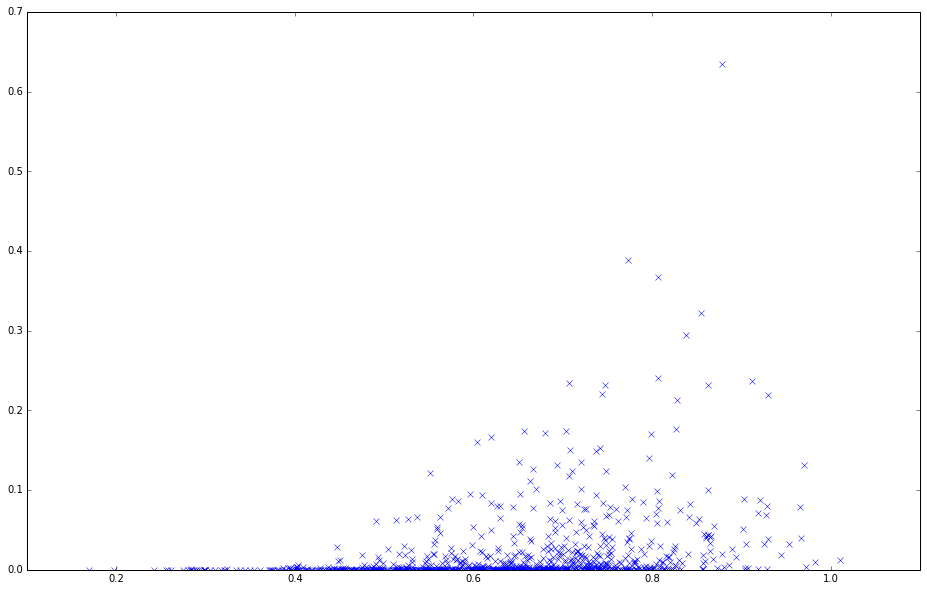

In [15]:
plt.plot(errors[:, 0], errors[:, 1], 'x')
#plt.ylim(0, 0.1)